## Simple variation of adversarial attack with MNIST

Example of a simple gradient-based adversarial attack, based on this [article](https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy,MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x = x_train[y_train <= 4][:30500] # using numbers 0...5
y = y_train[y_train <= 4][:30500]
print(x.shape,y.shape)

(30500, 28, 28) (30500,)


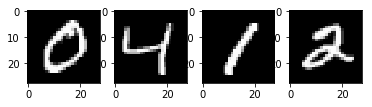

In [3]:
plt.subplot(1,4,1)
plt.imshow(x[0],cmap="gray")
plt.subplot(1,4,2)
plt.imshow(x[1],cmap="gray")
plt.subplot(1,4,3)
plt.imshow(x[2],cmap="gray")
plt.subplot(1,4,4)
plt.imshow(x[3],cmap="gray")
plt.show()

### Training the DNN MNIST model

In [4]:
def loss_func(y_true,y_pred):
    """ standard loss function
    """
    loss = SparseCategoricalCrossentropy()(y_true,y_pred)
    return loss

In [5]:
def compile_model(optimizer=Adam(lr=0.001)):
    """ model implementation
    """
    x = Input(shape=(28,28))
    x_f = Flatten()(x)
    h = Dense(256,activation='relu')(x_f)
    out = Dense(5,activation='softmax')(h)
    
    model = Model(inputs=x,outputs=out)
    model.compile(loss=loss_func,optimizer=optimizer)
    return model

In [6]:
model = compile_model()

In [7]:
n_epochs=3
batch_size=50
for epoch_i in range(n_epochs):
    losses = []
    for i in range(0,len(x),batch_size):
        x_train_subset = x[i:i+batch_size]
        y_train_subset = y[i:i+batch_size]
        batch_loss = model.train_on_batch(x_train_subset,y_train_subset)
        losses.append(float(batch_loss))
    print("Epoch {}: {}".format(epoch_i+1,sum(losses)/len(losses)))

Epoch 1: 2.6134243679609934
Epoch 2: 0.3061863711021354
Epoch 3: 0.18320664083961818


In [8]:
model.trainable=False # fixing the weights of the model

In [9]:
# sample prediction 
print("prediction:",np.argmax(model(np.expand_dims(x[0],axis=0))))
print("label:",y[0])

prediction: 0
label: 0.0


### Creating adversarial example

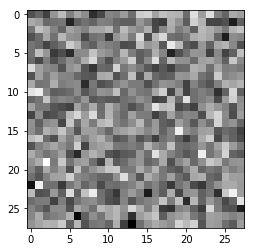

In [10]:
gen_x = tf.Variable(tf.random.normal((1,28,28),mean=0.0,stddev=0.05),trainable=True) # instantiation of new image
plt.imshow(np.squeeze(gen_x.numpy()),cmap="gray")
plt.show()

In [11]:
input_x = np.expand_dims(x[0],axis=0) # this is what we want our input to look like
lam = 0.5
suggested_y = np.ones((1,)).astype("float32")*3 # this is the label we want the model to believe our input is

optimizer=Adam(lr=0.01)
n_epochs=5000
for epoch_i in range(n_epochs):
    with tf.GradientTape() as tape:
        model_pred = model(gen_x)
        model_loss = loss_func(suggested_y,model_pred)
        identity_loss = MeanSquaredError()(input_x,gen_x)
        loss = model_loss+(lam*identity_loss)
    
    gradients = tape.gradient(loss,gen_x)
    optimizer.apply_gradients(zip([gradients],[gen_x]))

print(float(loss))

2651.86328125


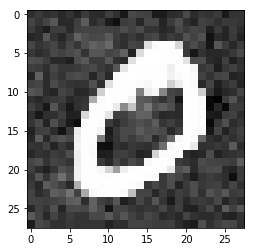

In [12]:
plt.imshow(np.squeeze(gen_x.numpy()),cmap="gray") # the generated image, clearly a 0
plt.show()

In [13]:
# tricked the model into thinking this 0 is actually a 3
print("prediction:",np.argmax(model(gen_x)))
model(gen_x)

prediction: 3


<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[1.7457709e-01, 9.4663097e-11, 8.0041327e-03, 8.1741875e-01,
        2.7881361e-10]], dtype=float32)>

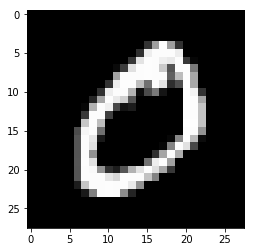

In [14]:
plt.imshow(np.squeeze(input_x),cmap="gray")
plt.show()

In [15]:
print("prediction:",np.argmax(model(input_x)))

prediction: 0
